<a href="https://colab.research.google.com/github/deepintomlf/mlfbook/blob/master/Chapter8_ReinforcementLearning/%E5%BE%AA%E7%8E%AF%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **第八章 - 循环强化学习**




这个Jupyter笔记本包含了第八章的所有源代码.

## 循环强化学习(RRL)
Recurrent Reinforcement Learning (RRL) is an adaptive approach of DR to solve the portfolio optimization problem, which can be simple re-interpreted as the RNN model. 

[[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=935097) Moody, J. and Saffell, M., 2001. Learning to trade via direct reinforcement. IEEE transactions on neural Networks, 12(4), pp.875-889.

**Goal**: To learn optimal trading stategy to maximize the Sharpe Ratio over the period.

**Problem setup**:


1.   $z_{t}$ is the price of the asset at time $t$;
2.   $r_{t}$ is the return at time $t$, i.e. $r_{t} = z_{t} - z_{t-1}$;
3.   $r_{t}^{f}$ is the risk-free return at time $t$;
4.   $F_{t}$ is the unit of the asset to trade at time $t$, where
\begin{eqnarray*}
F_{t} = \text{sign}\left({\color{blue}\mu} F_{t-1} + \sum_{ i = 0}^{p-1} {\color{blue}\nu_{i}} r_{t - i} + {\color{blue}\omega}\right),
\end{eqnarray*}
where $F_{t} \in \{ -1, 0, +1\}$, and ${\color{blue}\theta \equiv (\mu,\nu_{0} \cdots, \nu_{m}, \omega)}$ are model parameters
5.   $R_{t}$ is the trading return at time $t$, 
\begin{equation*}
R_{t} \equiv u \{ r_{t}^{f} + F_{t-1}(r_{t} - r_{t}^{f}) - \delta \vert F_{t} - F_{t-1} \vert \}.
\end{equation*}

The goal is to learn the optimal parameters to maximize the objective function (Sharpe Ratio $S_{T}$): 
\begin{eqnarray*}
S_{T} = \frac{\text{Average} (R_{t})}{\text{Standard Deviation} (R_{t})}.
\end{eqnarray*}

 ![alt text](https://docs.google.com/uc?export=download&id=1RuV5C928ow0JnSmlhP9tDp4arAUEbCrY)

## 递归神经网络
1.  Input Layer $(x_{t})_{t = 1}^{T}$: 
2. Hidden Layer $(s_{t})_{t = 1}^{T}$:
\begin{eqnarray*}
s_{t} = h({\color{blue}U}x_{t} + {\color{blue}W}s_{t-1}).
\end{eqnarray*}
3. Output Layer $(o_{t})_{t = 1}^{T}$:
\begin{eqnarray*}
o_{t} = g({\color{blue}V}s_{t})，
\end{eqnarray*}
where ${\color{blue}\theta } \equiv (U, W, V) $ are RNN parameters to learn from data.

 ![alt text](https://docs.google.com/uc?export=download&id=1TdW2XhSyK0o7shHV_nh2ywt9gS142Fra)

## 从RNN到RRL 


![alt text](https://docs.google.com/uc?export=download&id=1bzATrv561I9CND9akmjxCTpwhHk90EDo)


Let $x_t$ denote the $p$-lagged value of the return, i.e. $x_t  = (r_{t-p+1}, \cdots, r_{t})^{T}$.

1. **Input Layer** (Dark Green):  $(I_{t})_{t = p}^{T-1}$ where $I_{t} = \left( \begin{array}{c}x_{t}\\ r_{t+1}\\ \end{array} \right).$

2. **Hidden Layer** (Pink):  $(Y_{t})_{t = p}^{T-1}$ where  $Y_{t} = \left( \begin{array}{c} F_{t}\\ r_{t+1} \end{array} \right)$.  

  **Step 1**: We split the input layer into two parts: $(x_{t})_{t = p}^{T-1}$ and $(r_{t+1})_{t = p}^{T-1}$.

  **Step 2**: Set up the RNN Layer: $(x_{t})_{t = p}^{T-1} \rightarrow (F_{t})_{t = p}^{T-1}$ .

  **Step 3**: Merge  $(F_{t})_{t = p}^{T-1}$ and $(r_{t+1})_{t = p}^{T-1}$ to $(Y_{t})_{t = p}^{T-1}$. 
  

3. **Output Layer**(Blue):  $(R_{t})_{t = p}^{T-1}$, which can be directly computed from $(Y_{t})_{t = p}^{T-1}$  based on 
\begin{equation*}
R_{t} \equiv u \{ r_{t}^{f} + F_{t-1}(r_{t} - r_{t}^{f}) - \delta \vert F_{t} - F_{t-1} \vert \}.
\end{equation*}
for the given $r_{t}^{f}, \mu$ and $\delta$, as $Y_{t} = (F_{t}, r_{t+1})^{T}$.

4. **Loss Function**: 
\begin{eqnarray*}
S_{T} = \frac{\text{Average}(R_{t})}{\text{Standard Deviation}(R_{t})}
\end{eqnarray*}

![alt text](https://docs.google.com/uc?export=download&id=1xkEIBNrwNxiYd06Khr819i96YnAvT2H-)

### **定义神经网络的输出层**

In [0]:
import keras
import keras.backend as K
import tensorflow as tf

def split_func1(x):    
    '''
    输入: 回报;
    输出: p阶滞后项.
    '''
    p = x._keras_shape
    split1, split2 = tf.split(x, [p[-1]-1, 1], -1)
    return split1

def split_func2(x): 
    '''
    输入: 特征和回报序列;
    输出: 下一时刻的回报.
    '''
    p = x._keras_shape
    split1, split2 = tf.split(x,  [p[-1]-1, 1], -1)
    return split2
  
def TradingReturn(x, delta):
    ''' 定义输出层 '''   
    F_t_Layer, r_tplus1_Layer = tf.split(x, [1, 1], -1)
    p = x._keras_shape
    F_tminus1_layer1, f1 = tf.split(F_t_Layer, [p[-2]-1, 1], -2)
    f1, F_t_layer1 = tf.split(F_t_Layer, [1, p[-2]- 1], -2)
    transaction_part = delta*tf.abs(tf.subtract(F_t_layer1, F_tminus1_layer1))
    f1= tf.zeros(tf.shape(f1), dtype = float )
    transaction_part = tf.concat([f1, transaction_part], -2)
    output_layer  =  Multiply()([F_t_Layer, r_tplus1_Layer]) -transaction_part
    return output_layer

### **定义损失函数为输出层的负夏普比率**

In [0]:
def SharpeRatioLoss(yTrue,yPred):
    """
    functionality: compute the negative shapiro ratio for the given yTrue and yPred  
  
    parameters: 
    yTrue: none
    yPred: the return series of the given trading strategy
  
    returns:
    (scalar): the negative shapiro ratio of yPred
    """
    # 定义损失函数为负夏普比率
    B = K.mean(K.square(yPred))
    A = K.mean(yPred)
    return -A/((B-A**2)**0.5) 

### **为循环强化学习算法构建神经网络**

In [0]:
from keras.engine.topology import Layer
from keras import optimizers
from keras.layers import SimpleRNN, Dot, Dense, Activation, Input, Lambda, Add, Flatten,Multiply, Concatenate, Subtract
from keras.models import Model, Sequential


def RRL_Model(input_dim, delta):  
  """
  functionality: constract RRL model with the input layer ([X_ts, r_ts]), the output layer (the trading return) and the loss function(negative shapiro ratio)  
  
  parameters: 
  input_dim: input dimension (1, p, T-p) 
  delta(float): transaction rate
  
  returns:
  model(keras model): RRL model 
  """
  # 构建以交易回报序列为输出层、负夏普比率为损失函数的神经网络
  model = Sequential()
  input_layer = Input(shape=input_dim)
  # 步骤一: 将输入层分成X_t_layer和r_tplus1_layer两部分
  X_t_layer = Lambda(split_func1)(input_layer)
  r_tplus1_layer = Lambda(split_func2)(input_layer)   
  # 步骤二: 使用循环神经网络将X_t_layer映射到F_t_layer
  F_t_layer = SimpleRNN(1, input_shape=X_t_layer._keras_shape[-2:],activation = 'tanh', return_sequences = True, use_bias=True)(X_t_layer) # 
  # 步骤三: 合并F_t_layer和r_tplus1_layer
  hidden_layer = Concatenate()([F_t_layer, r_tplus1_layer])
  # 计算代表交易回报序列的输出层
  output_layer = Lambda(TradingReturn, arguments={'delta':delta})(hidden_layer )
  # 设置输入层和输出层
  model = Model(inputs=input_layer, outputs=output_layer)
  sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  # 设置自定义的SharpeRatioLoss()损失函数
  model.compile(loss=SharpeRatioLoss, optimizer=sgd)  
  return model

### **预测下一时刻交易策略**

In [0]:
from numpy import divide, power 

def NextWindow(weights, X_t, F_t):
  ''' 计算下一时刻交易策略F_tplus1 '''
  weight0 = weights[0].reshape(np.shape(X_t))   
  F_tplus1 = np.sign(np.dot(weight0, X_t) + weights[1][0]*F_t + weights[2])
  return F_tplus1

def Prediction(X, model, delta):
  '''
  计算交易策略、交易回报和夏普比率序列;
  输入：X-输入数据, model - RRL model, delta - 交易费;
  输出：F-交易策略序列, R-交易回报序列, D-夏普比率序列.
  '''
  weights = model.get_weights() 
  F = np.zeros(np.shape(X)[1], dtype = float)  
  R = np.zeros(np.shape(X)[1], dtype = float)  
  l = np.shape(F)[0]
  
  for i in range(l-1):  
    F[i+1] = NextWindow(weights, X[0, i, :-1], F[i])
    R[i+1] = F[i+1]*X[0, i, -1]-delta*(np.abs(F[i+1] - F[i]))
    
  A = np.zeros(np.shape(F))
  B = np.zeros(np.shape(F))
  D = np.zeros(np.shape(F))
  var_R = np.zeros(np.shape(F))
  A[1:] = divide(np.cumsum(R)[1:], np.arange(l)[1:])
  B[1:] = np.divide(np.cumsum(np.power(R, 2))[1:], np.arange(l)[1:])
  var_R[2:] = B[2:]- power(A, 2)[2:]
  D[2:] =  A[2:]/ np.sqrt(var_R[2:])
  return F, R, D

## **数值实验: 算法交易**

###**模拟人工价格过程**



We generate log price series $(p(t))_{t = 1}^{T}$ based on the following models:
\begin{eqnarray}
p(t) &=& p(t-1) + \beta(t-1) + k \varepsilon(t),\\
\beta(t)& =&\alpha \beta(t-1) + \epsilon(t),
\end{eqnarray}
where $\alpha = 0.9$ and $k =3$, $(\varepsilon(t),\epsilon(t))$ is a two dimensional standard normal distributed variable. The artificial price series $z(t)$ is defined as 
\begin{eqnarray*}
z(t) = \exp\left(\frac{p(t)}{R}\right),
\end{eqnarray*}
where $R: = \max_t(p(t)) - \min_t(p(t))$ over a simulation with $T = 10,000$.

In [0]:
import numpy as np

# 固定随机数种子
np.random.seed(42)

# 生成长度为T的人工价格数据
def SimulateData(T):
    """
    functionality: Simulate a time series p(t) of length T, which satisfies that
    p[i+1] = p[i] + b[i] + 3e1[i];
    b[i] = 0.9*b[i-1] + e2[i];
    z = exp(p/range(p)).
    """
    # 将p和b初始化长度为T的零数组
    p = np.zeros((T),  float)
    b = np.zeros((T),  float)
    # 循环生成数组p和b 
    for i in range(T-1):
        p[i+1] = p[i] + b[i] + 3*np.random.randn()
        b[i+1] = 0.9*b[i] + np.random.randn()
    # 计算数组z
    R = np.max(p) - np.min(p)
    z = np.exp(p/R)
    return z

# 生成10,000个模拟样本
z = SimulateData(T= 10000)

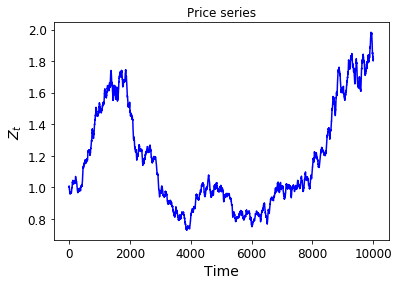

In [30]:
import matplotlib.pyplot as plt

# 绘制人工价格曲线
plt.plot(z, 'b')
plt.title('Price series')
plt.xlabel('Time')
plt.ylabel('$Z_t$')
plt.show()


### **预处理人工价格数据**

In [0]:
def ConstructTimeSeriesWithMultiFeatures(market_info, id_t_start, id_t_end, n_lagged_time_steps ):
    """
    Functionality:
    To construct p-lagged return series X_ts and return series r_ts from price time series;
    market_info from any time period with index ranging from id_t_start to id_t_end.
  
    Parameters:
    market_info (numpy): one-dimensional price time series;
    id_t_start (int): the index of the starting time;
    id_t_end (int): the index of the end time;
    n_lagged_time_steps (int): the lagged values.
  
    Returns:
    X_ts (numpy): the p-lagged return series;
    r_ts (numpy): the return series.
    """
    # price表示从id_t_start到id_t_end的价格序列
    price = market_info[id_t_start:id_t_end]
    # 计算回报序列
    returnIndex = np.diff(price) 
    # 计算n_lagged_time_steps阶滞后项回报序列(特征集)和下一时刻回报
    X_ts = np.zeros((len(price) - n_lagged_time_steps-1, n_lagged_time_steps)) 
    for i in range(X_ts.shape[0]):
        X_ts[i,:] = returnIndex[np.arange(i, i + n_lagged_time_steps,1)]
    r_ts = returnIndex[n_lagged_time_steps:] 
    return X_ts, r_ts
  
X_ts, r_ts = ConstructTimeSeriesWithMultiFeatures(z, id_t_start=0, id_t_end=10000, n_lagged_time_steps=8)

In [0]:
from sklearn import preprocessing
r_ts = np.reshape(r_ts, np.shape(r_ts)+(1,))
# 标准化输入数据
window_train = 2000
scaler = preprocessing.StandardScaler().fit(X_ts[:window_train])
X_ts = scaler.transform(X_ts)

### **在人工价格数据集上训练循环强化学习模型**

In [33]:
def ReshapeInput(X_ts, r_ts): 
    '''
    输入: X_ts - 滞后项回报序列, 形状为[T, p];
          r_ts - 下一时刻回报, 形状为[T, 1].
    输出: 形状为[1, nTimeSteps, nFeatures]的[X_ts, r_ts], 其中nTimeSteps=T, nFeatures=p+1.
    '''
    X = np.concatenate([X_ts, r_ts], axis=1)
    X = np.reshape(X, (1,)+np.shape(X))
    return X
  
# 划分训练集和测试集, 形状与RRL模型相匹配.
trainX = ReshapeInput(X_ts[:window_train], r_ts[:window_train]) 
testX = ReshapeInput(X_ts[window_train:], r_ts[window_train:])

# 设置交易费
delta = 0.002

# 构建RRL模型
model = RRL_Model(np.shape(trainX)[1:], delta)
print(model.summary())
model.fit(trainX[:window_train], trainX[:window_train], epochs=200, verbose=2)

W0617 07:58:43.228177 140064862656384 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 07:58:43.274811 140064862656384 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 07:58:43.302109 140064862656384 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 07:58:43.456516 140064862656384 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0617 07:58:43.570435 140064862656384 deprecation.py:323

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000, 9)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2000, 8)      0           input_1[0][0]                    
__________________________________________________________________________________________________
simple_rnn_1 (SimpleRNN)        (None, 2000, 1)      10          lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2000, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

W0617 07:58:43.749387 140064862656384 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0617 07:58:43.767810 140064862656384 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/200
 - 1s - loss: 0.6920
Epoch 2/200
 - 0s - loss: 0.6904
Epoch 3/200
 - 0s - loss: 0.6881
Epoch 4/200
 - 0s - loss: 0.6852
Epoch 5/200
 - 0s - loss: 0.6816
Epoch 6/200
 - 0s - loss: 0.6774
Epoch 7/200
 - 0s - loss: 0.6726
Epoch 8/200
 - 0s - loss: 0.6672
Epoch 9/200
 - 0s - loss: 0.6612
Epoch 10/200
 - 0s - loss: 0.6546
Epoch 11/200
 - 0s - loss: 0.6473
Epoch 12/200
 - 0s - loss: 0.6395
Epoch 13/200
 - 0s - loss: 0.6309
Epoch 14/200
 - 0s - loss: 0.6216
Epoch 15/200
 - 0s - loss: 0.6111
Epoch 16/200
 - 0s - loss: 0.5993
Epoch 17/200
 - 0s - loss: 0.5861
Epoch 18/200
 - 0s - loss: 0.5715
Epoch 19/200
 - 0s - loss: 0.5552
Epoch 20/200
 - 0s - loss: 0.5377
Epoch 21/200
 - 0s - loss: 0.5191
Epoch 22/200
 - 0s - loss: 0.4990
Epoch 23/200
 - 0s - loss: 0.4770
Epoch 24/200
 - 0s - loss: 0.4536
Epoch 25/200
 - 0s - loss: 0.4288
Epoch 26/200
 - 0s - loss: 0.4018
Epoch 27/200
 - 0s - loss: 0.3677
Epoch 28/200
 - 0s - loss: 0.3257
Epoch 29/200
 - 0s - loss: 0.2776
Epoch 30/200
 - 0s - lo

In [34]:
# 查看模型参数
weights = model.get_weights()
print('The coefficients of p-lagged values: {}'.format(weights[0]))
print('The coefficients of the previous F(t-1): {}'.format(weights[1]))
print('The bias: {}'.format(weights[2]))

The coefficients of p-lagged values: [[0.1770324 ]
 [0.7909564 ]
 [0.71531254]
 [0.4833581 ]
 [0.14925078]
 [0.5534418 ]
 [0.5022752 ]
 [0.44672918]]
The coefficients of the previous F(t-1): [[1.6869678]]
The bias: [1.0799011]


### **在测试集上评估循环强化学习模型**

Given $\theta$ and $F_{0} =0$, at each time $t$, we can evaluate the trading Strategy $F_{t}$:
\begin{eqnarray*}
F_{t} = \text{sign}\left({\color{blue}\mu} F_{t-1} + \sum_{ i = 0}^{p-1} {\color{blue}\nu_{i}} r_{t - i} + {\color{blue}\omega}\right),
\end{eqnarray*}
where $F_{t} \in \{ -1, 0, +1\}$, and ${\color{blue}\theta \equiv (\mu,\nu_{0} \cdots, \nu_{m}, \omega)}$ are model parameters.

W0617 12:03:04.099508 140064862656384 legend.py:1383] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

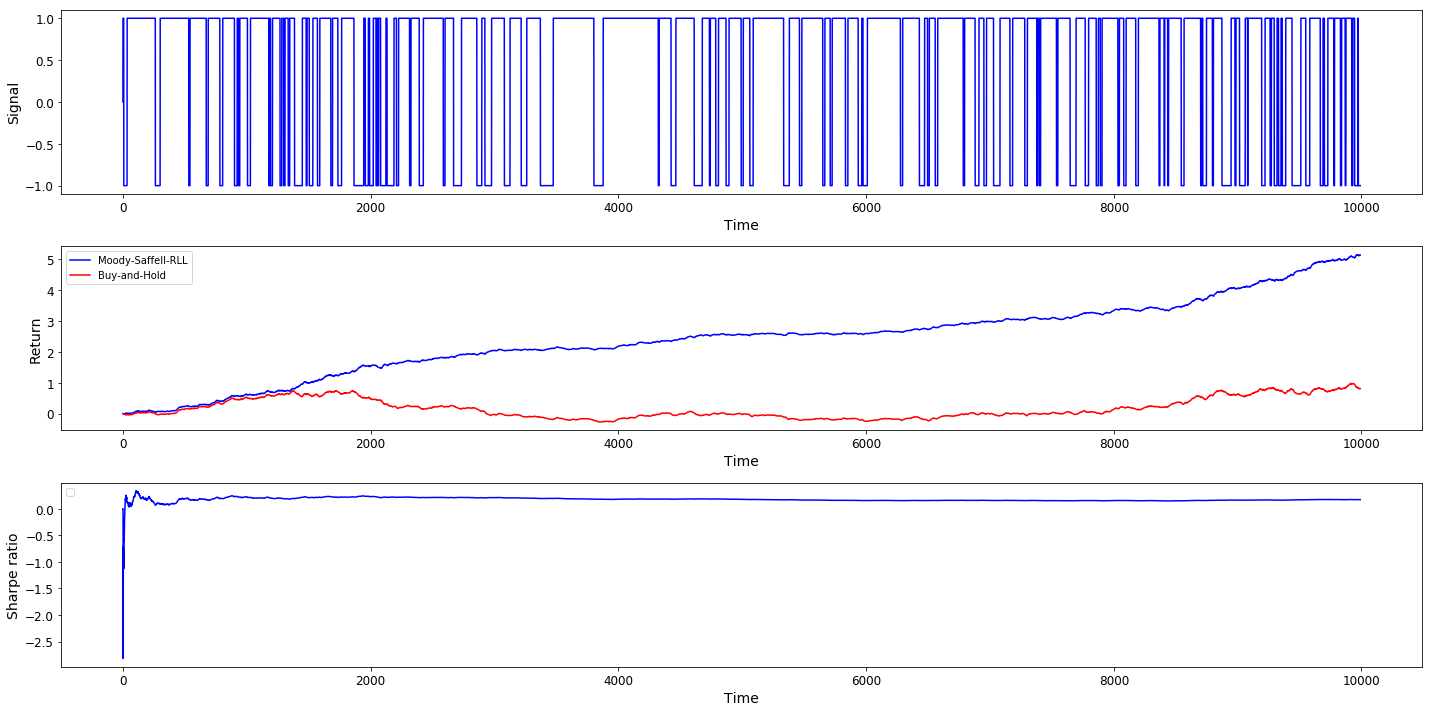

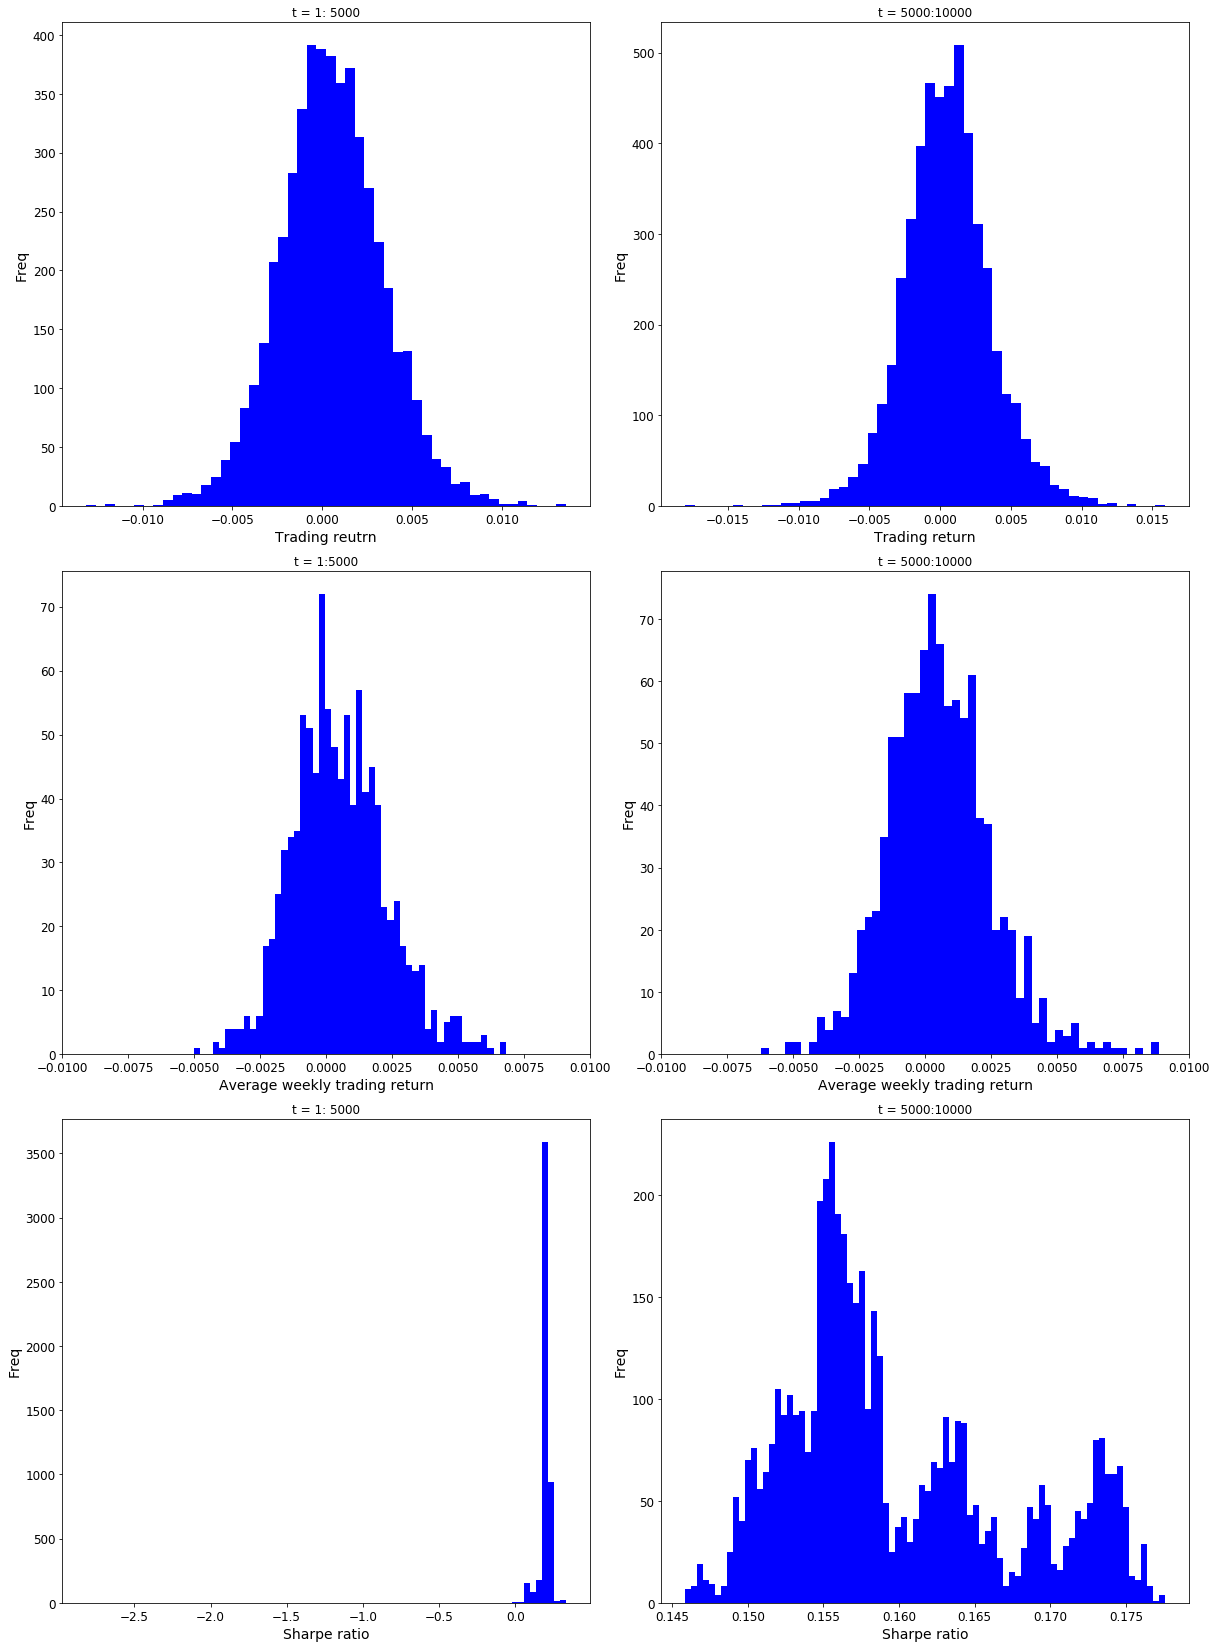

In [54]:
def Plot_Price_F_Profit_SharpeR(r, F, R, D):
  ''' 绘制交易策略、交易回报和夏普比率序列 '''
  plt.tight_layout()
  plt.subplots(3,1,figsize=(20,10))
  plt.subplot(3,1,1)
  plt.plot(F, 'b')
  plt.xlabel('Time')
  plt.ylabel('Signal')
  plt.subplot(3,1,2)
  plt.plot(np.cumsum(R), 'b', label="Moody-Saffell-RLL")
  plt.plot(np.cumsum(r), 'r',label="Buy-and-Hold")
  plt.xlabel('Time')
  plt.ylabel('Return')
  plt.legend(loc="upper left")
  plt.subplot(3,1,3)
  plt.plot(D, 'b')
  plt.xlabel('Time')
  plt.ylabel('Sharpe ratio')
  plt.legend(loc="upper left")
  plt.tight_layout()
  plt.show()
  
def PlotAverageWeeklyReturn(R):
    ''' 绘制每周平均交易回报的直方图 '''
    l = np.int(np.floor(np.shape(R)[0]/5))
    avgProfit = R[: l*5].reshape(l, 5)
    avgProfit = np.mean(avgProfit, 1)
    plt.hist(avgProfit, bins=50, color='b')
    plt.xlim((-0.01, 0.01))  
    
def Plot_Hist_R_SharpR(R, D): 
  '''
  绘制每日交易回报、每周平均交易回报和夏普比率的直方图;
  左图是时刻t=1:5000的数据, 右图是时刻t=5000:10000的数据.
  '''
  plt.subplots(3,2,figsize=(17, 23))
  plt.subplot(3, 2, 1)
  plt.hist(R[:5000], 50, color='b')
  plt.xlabel('Trading reutrn')
  plt.ylabel('Freq')
  plt.title('t = 1: 5000')
  plt.subplot(3, 2, 2)
  plt.hist(R[5000:], 50, color='b')
  plt.xlabel('Trading return')
  plt.ylabel('Freq')
  plt.title('t = 5000:10000') 
  plt.subplot(3, 2, 3)
  PlotAverageWeeklyReturn(R[:5000])
  plt.xlabel('Average weekly trading return')
  plt.ylabel('Freq')
  plt.title('t = 1:5000')
  plt.subplot(3, 2, 4)  
  PlotAverageWeeklyReturn(R[5000:])
  plt.xlabel('Average weekly trading return')
  plt.ylabel('Freq')
  plt.title('t = 5000:10000')
  plt.subplot(3, 2, 5)
  plt.hist(D[:5000], 80, color='b')
  plt.xlabel('Sharpe ratio')
  plt.ylabel('Freq')
  plt.title('t = 1: 5000')
  plt.subplot(3, 2, 6)
  plt.hist(D[5000:], 80, color='b')
  plt.xlabel('Sharpe ratio')
  plt.ylabel('Freq')
  plt.title('t = 5000:10000')
  plt.tight_layout()
  plt.show()
  
# 计算交易策略、交易回报和夏普比率序列
X = ReshapeInput(X_ts, r_ts)
F, R, D = Prediction(X, model, delta)

Plot_Price_F_Profit_SharpeR(r_ts, F, R, D)
Plot_Hist_R_SharpR(R, D)

